# Exploring and Processing the Data

In this notebook, we will begin analyzing the data. The dataset of focus here is a dataset of musical instrument reviews from Amazon. The end goal will be to categorize them as good, bad, or neutral. The data comes from Kaggle: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews/discussion/161304.

In [10]:
#import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [33]:
df = pd.read_json('../data/Musical_Instruments_5.json', lines=True)

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Data Definition

In [37]:
df.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


So there are no null values in all columns except the reviewerName column. As expected, the overall column is of type int. The unixReviewTime is in seconds, and of type int, but this column will likely not be of any use. From the describe method above, it looks like most rerviews are positive. This may cause issues later.

The columns with explanations are as follows:
 - reviewerID: the ID of the reviewer
 - asin: the ID of the product
 - reviewerName: the name of the reviewer
 - helpful: helpfulness rating of the review
 - reviewText: the actual review, in longform text
 - overall: the rating of the product
 - summary: a quick summary of the text review
 - unixReviewTime: the time of the review, in seconds from Jan 1 1970
 - reviewTime: the time of the review, in datetime format


## Data Cleaning and Exploring

Let's now clean the data and explore it a little bit as well. Since the most important part of this data is text, we can't explore everything too well now, but we can after pre-processing it. The final two columns are based on time, and we won't spend any time on it here yet because they are not of any relevance at the moment.

**reviewerName:**

In [51]:
df[df['reviewerName'].isna()].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
41,AA5TINW2RJ195,B000068NW5,NaN,"[0, 0]",Good quality cable and sounds very good,5,Five Stars,1405382400,"07 15, 2014"
263,A14VAT5EAX3D9S,B0002CZSJO,NaN,"[0, 0]",It is exactly what you need in a capo! You can...,5,Great,1364860800,"04 2, 2013"
264,A2RVY2GDMZHH4,B0002CZSJO,NaN,"[0, 0]",Love these capos and nice that you can get the...,5,Always great Kyser,1356652800,"12 28, 2012"
432,A3BMYEA3J6RBVV,B0002CZVB4,NaN,"[0, 0]",Bought it as a gift. Friend loved it very much.,5,Friend loved it very much,1405209600,"07 13, 2014"
667,AA5TINW2RJ195,B0002D01K4,NaN,"[0, 0]",At first it look small for my guitar but it fi...,5,Love it!,1405382400,"07 15, 2014"


In [56]:
print('Number of missing reviewerNames:', df[df['reviewerName'].isna()].shape[0])

Number of missing reviewerNames: 27


It looks like there are not many reviews that are missing names, when considering that the data has 10261 reviews. This means we could comfortably remove these reviews, but because we are doing sentiment analysis and we don't care about the reviewer names at the moment, we will just leave them in.

**reviewerID and asin:**

In [63]:
print('Number of unique reviewers:', len(df['reviewerID'].unique()))
print('Number of unique instruments/products:', len(df['asin'].unique()))

Number of unique reviewers: 1429
Number of unique instruments/products: 900


So there are many repeat reviewers. This means each reviewer reviewed a product roughly 7 times. Similarly, each product was reviewed about 11 times. This is a naive way to approach the number of reviews here this way, since it was just simple division, but we can double check this by counting them now. 

We can do this by taking a using the counter function on the values of the columns. This will output a dict, with the values being the frequency of the reiviewer or instrument ID's. Taking another counter of this will let us see how many times a reviewer reviewed a product, or how many times an instrument was reviewed.

In [77]:
#seeing how many times a reviewer reviewed an instrument
Counter(Counter(df['reviewerID']).values()).most_common(5)

[(5, 558), (6, 296), (7, 188), (8, 128), (9, 71)]

In [78]:
#seeing how many times an instrument was reviewed
Counter(Counter(df['asin']).values()).most_common(5)

[(5, 197), (6, 141), (7, 107), (8, 77), (9, 61)]

So the simple division was naive indeed, as both of these cases had about 5-9 reviews only most of the time. In any case, this might be useful information later on, where we can see if a certain reviewer tends to rate more positively or not, or more importantly, if an instrument get more positive or negative reviews.


**helpful:**

The next column to deal with is the helpful column. This has values in the form of lists with two values, the first being the number of thumbs up a reivew got, indicating how helpful the review was, and the second value is the total number of people who rated the review (i.e. the number of people who gave the review a thumbs up + the number of thumbs down). This is an interesting metric that can tell us how useful a review was, and maybe give us an idea of how we could introduce weights to each review.

In [114]:
df[df['helpful'].apply(lambda x: [0, 0] != x)].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
10,A2NYK9KWFMJV4Y,B00004Y2UT,"Mike Tarrani ""Jazz Drummer""","[6, 6]","Monster makes a wide array of cables, includin...",5,One of the best instrument cables within the b...,1334793600,"04 19, 2012"
18,A2EZWZ8MBEDOLN,B000068NSX,Charlo,"[3, 3]",I've been using these cables for more than 4 m...,5,So far so good. Will revisit at the 6 month m...,1363564800,"03 18, 2013"
28,A2CCGGDGZ694CT,B000068NVI,b carney,"[1, 1]",The Hosa XLR cables are affordable and very he...,4,Very Heavy Cables At Affordable Price,1341964800,"07 11, 2012"


Unfortunately, not all reviews have any thumbs up or thumbs down reivews. In fact, about 34% of reviews have ratings for them. It would be too hard to introduce anything from that, unless we ignored the non-rated reviews. Perhaps this is still something to consider later though.

**reviewText and summary:**

Now we consider the most important columns, that is the reviewText and the summary columns. These are the text columns that we will use to predict the overall column (which we will modify later into classes). In principal, we only need the reviewText column, but we can clean the summary column while we clean the reviewText column anyways, and use them both should we choose.

In [124]:
#lets make a copy of the dataframe first, since this is where the important cleaning begins
df_clean = df.copy()

In [125]:
# recall the time columns are not relavant, so we will remove them here
df_clean = df_clean.drop(columns = ['unixReviewTime', 'reviewTime'])

#also going to reorder columns so overall is last
df_clean = df_clean[['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'summary', 'overall']]

In [126]:
#first, we can make the text lower case
df_clean['reviewText'] = df_clean['reviewText'].apply(lambda x: x.lower())
df_clean['summary'] = df_clean['summary'].apply(lambda x: x.lower())

In [127]:
df_clean.head()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,overall
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","not much to write about here, but it does exac...",good,5
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",the product does exactly as it should and is q...,jake,5
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",the primary job of this device is to block the...,it does the job well,5
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",nice windscreen protects my mxl mic and preven...,good windscreen for the money,5
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",this pop filter is great. it looks and perform...,no more pops when i record my vocals.,5


**overall:**

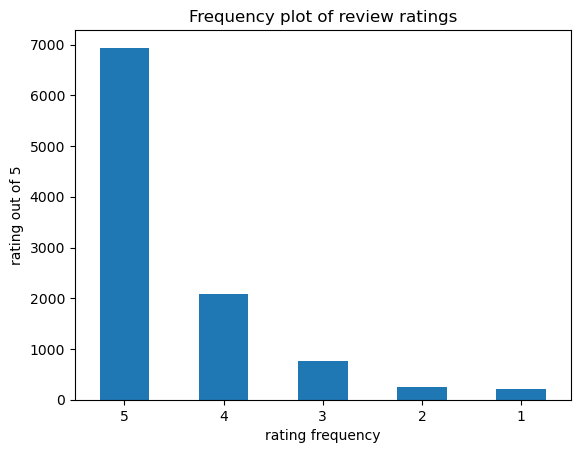

In [154]:
df_clean['overall'].value_counts().plot.bar(rot=0)
plt.title('Frequency plot of review ratings')
plt.xlabel('rating frequency')
plt.ylabel('rating out of 5')
plt.show()

In [136]:
dct = {5:'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'}

df_clean['overall'].apply(lambda x: dct[x])

0        good
1        good
2        good
3        good
4        good
         ... 
10256    good
10257    good
10258    good
10259    good
10260    good
Name: overall, Length: 10261, dtype: object